In [ ]:
#https://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py

In [ ]:
#В связи с недавним обновлением библиотеки gym, попытки создать игровую среду pong-v0 (или любую другую) теперь вызывают ошибку. 
#Следующий код является временной мерой для избежание этой ошибки.

!pip install gym==0.18.0
!pip install atari-py==0.2.5
!pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 3.9 MB/s 
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656450 sha256=14b8936da556d0ed59a97d1e3a3a3bccd362bbf68e037db310589948981e5bfc
  Stored in directory: /root/.cache/pip/wheels/99/f7/e3/d6f0f120ac047c1e5de2ae34930e7bf6e8de1c7a4d5fa68555
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 4.3 MB/s 
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███

In [ ]:
import tensorflow_probability as tfp                       #Импортируем библиотеку - Тензорфлоу Вероятности (позволяет генерить рандомные значения из заданного распределения в тензорфлоу)
import tensorflow as tf                                    #Импортируем Тензорфлоу

import gym                                                 #Импортируем среду Gym
import numpy as np                                         #Импортируем библиотеку NumPy
from tensorflow.keras.models import Model                  #Импортируем класс для создания модели с кераса
from tensorflow.keras.layers import *                      #Импортируем все слои с Кераса
from tensorflow.keras import utils                         #Импортируем утилиты Кераса
from tensorflow.keras.optimizers import RMSprop, Adam      #Импортируем оптимизаторы Кераса
from tensorflow.keras import backend as K                  #Импортируем бэкэнд Кераса
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from google.colab import output                            #Импортируем функцию для управления вывода в колаб-ячейках
from IPython.display import display, clear_output
import random

In [ ]:
#Гиперпараметры

gamma = 0.99
tau = 1e-2
batch_size = 64
actor_learning_rate = 1e-4
critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
memory_buffer_size = 100000

num_training_episodes = 200
max_steps_per_episode = 1000
EPSILON = 1e-16

In [ ]:
class Memory_Buffer:
  def __init__(self, state_space, action_space, memory_size=100000):
      self.current_states = np.empty((0, state_space), dtype=np.float64)
      self.actions = np.empty((0, action_space), dtype=np.float64)
      self.rewards = np.empty((0, 1), dtype=np.float64)
      self.next_states = np.empty((0, state_space), dtype=np.float64)
      self.dones = np.empty((0, 1), dtype=np.float64)
      self.total_size = 0
      self.memory_size = memory_size
    
  def add_to_memory(self, current_state, action, reward, next_state, done):
        self.current_states = np.append(self.current_states[-self.memory_size:], np.array(current_state, ndmin=2), axis=0)
        self.actions = np.append(self.actions[-self.memory_size:], np.array(action, ndmin=2), axis=0)
        self.rewards = np.append(self.rewards[-self.memory_size:], np.array(reward, ndmin=2), axis=0)
        self.next_states = np.append(self.next_states[-self.memory_size:], np.array(next_state, ndmin=2), axis=0)
        self.dones = np.append(self.dones[-self.memory_size:], np.array(done, ndmin=2), axis=0)
        self.total_size += 1
    
  def sample_from_memory(self):
    if batch_size > self.total_size:
      num_samples = self.total_size

    idx = np.random.choice(range(min(self.total_size, self.memory_size)), size=batch_size, replace=False)
    current_states = self.current_states[idx]
    actions = self.actions[idx]
    rewards = self.rewards[idx]
    next_states = self.next_states[idx]
    dones = self.dones[idx]

    return current_states, actions, rewards, next_states, dones

# class Memory_Buffer:
#   def __init__(self, memory_size):
#     self.memory_size = int(memory_size)
#     self.buffer = np.zeros((memory_size, 5)).astype(object)
#     self.counter = 0
    
#   def add_to_memory(self, state, action, reward, next_state, done):
#     position_to_write = self.counter % self.memory_size
#     self.buffer[position_to_write] = (state, action, reward, next_state, done)
#     self.counter += 1
    
#   def sample_from_memory(self):
#     batch = self.buffer[np.random.choice(min(self.counter, self.memory_size), batch_size, replace=False)]
#     current_states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
#     return current_states, actions, rewards, next_states, dones

In [ ]:
def create_actor(state_size, action_size):
  input = Input(shape = (state_size,))
  x = Dense(32, activation = 'relu')(input)
  x = Dense(32, activation = 'relu')(x)
  mean_output = Dense(action_size)(x)
  log_std_output = Dense(action_size)(x)
  model = Model(input, [mean_output, log_std_output])
  optimizer = Adam(learning_rate = actor_learning_rate)
  return model, optimizer

def create_critic(state_size, action_size):
  input_state = Input(shape = (state_size,))
  input_action = Input(shape = (action_size,))
  x = Concatenate()([input_state, input_action])
  x = Dense(32, activation = 'relu')(x)
  x = Dense(32, activation = 'relu')(x)
  output = Dense(1)(x)
  model = Model([input_state, input_action], output)
  optimizer = Adam(learning_rate = critic_learning_rate)
  return model, optimizer

env = gym.make("MountainCarContinuous-v0")

action_size = env.action_space.shape[0]
state_size  = env.observation_space.shape[0]

actor_network, actor_optimizer = create_actor(state_size, action_size)
main_critic_network_1, critic_optimizer_1 = create_critic(state_size, action_size)
main_critic_network_2, critic_optimizer_2 = create_critic(state_size, action_size)
target_critic_network_1, _ = create_critic(state_size, action_size)
target_critic_network_2, _ = create_critic(state_size, action_size)
alpha_optimizer = Adam(learning_rate = 1e-4)

alpha = tf.Variable(0.0, dtype=tf.float32)
target_entropy = -tf.constant(action_size, dtype=tf.float32)

memory_buffer = Memory_Buffer(state_size, action_size, memory_buffer_size)

In [ ]:
#Объявляем функцию для мягкого обновления весов целевых моделей.
#Данная функция вызовается в каждом моменте обучения, но каждый раз всего "немного" обновляет веса. 
#Это делается, чтобы целевые модели отличались от основных, но всё таки обновлялись в каждой итерации обучения.
@tf.function
def update_target_weights(main_weights, target_weights): #Функция принимает на вход веса основной модели и целевой модели
  for (main, target) in zip(main_weights, target_weights):       #В цикле проходимся по весам и смещениям каждого слоя
    target.assign(tau * main + (1 - tau) * target)               #Делаем "мягкое" обновление с гиперпараметром tau

In [ ]:
def actor_network_predict(state):
  mu, log_sigma = actor_network(state)
  sigma = tf.exp(log_sigma)
  dist = tfp.distributions.Normal(mu, sigma)
  action = dist.sample()

  # Apply the tanh squashing to keep the gaussian bounded in (-1,1)
  action = tf.tanh(action)

  # Calculate the log probability
  log_pi = dist.log_prob(action)
  # Change log probability to account for tanh squashing as mentioned in
  # Appendix C of the paper
  log_pi = log_pi - tf.reduce_sum(tf.math.log(1 - action**2 + EPSILON), axis=1, keepdims=True)

  return action, log_pi

In [ ]:
def sample_action(state):
  result = np.array(actor_network_predict(np.expand_dims(state, axis = 0))[0]).flatten()
  return result

def train_critic_networks(current_states, actions, rewards, next_states, dones):
  with tf.GradientTape() as tape_1:
    q1_predictions = main_critic_network_1([current_states, actions])
    mean_pred, log_std_pred = actor_network_predict(current_states)
    q1_targets = target_critic_network_1([current_states, mean_pred])
    q2_targets = target_critic_network_2([current_states, mean_pred])

    min_q_targets = tf.minimum(q1_targets, q2_targets)
    soft_q_targets = min_q_targets - alpha * log_std_pred
    q_targets = tf.stop_gradient(rewards + gamma * dones * soft_q_targets)
    critic_1_loss = tf.reduce_mean(tf.math.square(q1_predictions - q_targets))

  with tf.GradientTape() as tape_2:
    q2_predictions = main_critic_network_2([current_states, actions])
    mean_pred, log_std_pred = actor_network_predict(current_states)
    q1_targets = target_critic_network_1([next_states, mean_pred])
    q2_targets = target_critic_network_2([next_states, mean_pred])

    min_q_targets = tf.minimum(q1_targets, q2_targets)
    soft_q_targets = min_q_targets - alpha * log_std_pred
    q_targets = tf.stop_gradient(rewards + gamma * dones * soft_q_targets)
    critic_2_loss = tf.reduce_mean(tf.math.square(q2_predictions - q_targets))

  q1_gradients = tape_1.gradient(critic_1_loss, main_critic_network_1.trainable_variables)
  critic_optimizer_1.apply_gradients(zip(q1_gradients, main_critic_network_1.trainable_variables))

  q2_gradients = tape_2.gradient(critic_2_loss, main_critic_network_2.trainable_variables)
  critic_optimizer_2.apply_gradients(zip(q2_gradients, main_critic_network_2.trainable_variables))

  return critic_1_loss, critic_2_loss

def train_actor_network(current_states):
  with tf.GradientTape() as tape:
    mean_pred, log_std_pred = actor_network_predict(current_states)
    q1_predictions = main_critic_network_1([current_states, mean_pred])
    q2_predictions = main_critic_network_2([current_states, mean_pred])
    min_q_targets = tf.minimum(q1_predictions, q2_predictions)
    soft_q_targets = min_q_targets - alpha * log_std_pred
    actor_loss = -tf.reduce_mean(soft_q_targets)

  gradients = tape.gradient(actor_loss, actor_network.trainable_variables)
  actor_optimizer.apply_gradients(zip(gradients, actor_network.trainable_variables))

  return actor_loss

def train_alpha(current_states):
  with tf.GradientTape() as tape:
    mean_pred, log_std_pred = actor_network_predict(current_states)
    alpha_loss = tf.reduce_mean(-alpha*(log_std_pred + target_entropy))
  gradients = tape.gradient(alpha_loss, [alpha])
  alpha_optimizer.apply_gradients(zip(gradients, [alpha]))

  return alpha_loss

def train_algorithm():
  current_states, actions, rewards, next_states, dones = memory_buffer.sample_from_memory()
  critic_1_loss, critic_2_loss = train_critic_networks(current_states, actions, rewards, next_states, dones)
  actor_loss = train_actor_network(current_states)
  alpha_loss = train_alpha(current_states)
  update_target_weights(main_critic_network_1.trainable_variables, target_critic_network_1.trainable_variables)
  update_target_weights(main_critic_network_2.trainable_variables, target_critic_network_2.trainable_variables)

In [ ]:
#Создаем функцию для визуализации результата - принимает на вход массив вознаграждений за все эпизоды
def plot_results(rewards):
  output.clear() #Удаляем предидущий вывод ячейки
  plt.figure(figsize = (16, 10)) #Делаем размер графика большим
  plt.plot(rewards, color = 'blue', label = "Вознаграждения за эпизод (сырая)")                                                 #Отрисовываем вознаграждения за эпизоды
  plt.plot(moving_average(rewards), color = 'green', linestyle = '--', label = "Вознаграждения за эпизод (скользящая средняя)") #Отрисовываем скользящие средние вознаграждения
  plt.xlabel("Эпизод", fontsize = 14)                                                                                           #Добавляем лейбл для оси х
  plt.title("История наград во время обучения", fontsize = 20)                                                                  #Добавляем заголовок

  plt.legend()        #Отображаем легенду
  plt.show()          #Отображаем график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 10 значений.

def moving_average(data, width = 10): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), np.array(data).squeeze()])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

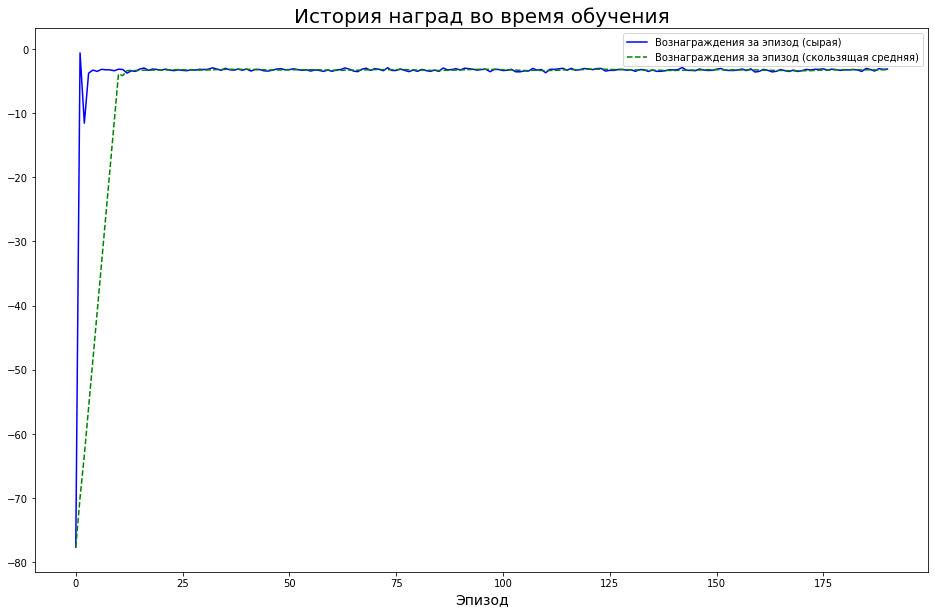

Starting episode 192
episode reward = -3.2601421917218447
Starting episode 193
episode reward = -3.2682534584856007
Starting episode 194
episode reward = -3.393357147876973
Starting episode 195
episode reward = -3.192596018619569
Starting episode 196
episode reward = -3.580481685039315
Starting episode 197
episode reward = -3.1300555188903716
Starting episode 198
episode reward = -3.028387301002923
Starting episode 199
episode reward = -3.542127737503877
Starting episode 200
episode reward = -3.2631783920663238


In [ ]:
episode_rewards = []

for i in range(num_training_episodes):
  print("Starting episode", i+1)
  current_state = next_state = env.reset()
  episode_reward = 0
  done = False
  step = 0
  while not done and step <= max_steps_per_episode:
    if memory_buffer.total_size >= batch_size * 2:
      action = sample_action(current_state)
    else:
      action = env.action_space.sample()
    next_state, reward, done, info = env.step(2 * action)
    memory_buffer.add_to_memory(current_state, action, reward, next_state, done)

    current_state = next_state
    episode_reward += reward

    if memory_buffer.total_size >= batch_size:
      train_algorithm()
    step += 1

  episode_rewards.append(episode_reward)
  print("episode reward =", episode_reward)
  if i > 0 and i % 10 == 0:
    plot_results(episode_rewards)